In [1]:
import numpy as np
import pandas as pd

In [2]:
# 경고 메세지 숨기기
import warnings
warnings.filterwarnings(action='ignore') 

In [3]:
#01. 데이터 불러오기
df = pd.read_csv('../data/drama_최종.csv',encoding='cp949',engine='python')

In [4]:
drama_mat = df

### 모델링
- linear regression
- random forest
- xgboosting

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.tree import DecisionTreeRegressor
# import xgboost as xgb
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import math
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use(['seaborn-whitegrid'])
%matplotlib inline
#  한글글꼴로 변경
plt.rcParams['font.size'] = 12.0
plt.rcParams['font.family'] = 'Malgun Gothic'
# 음수 표시 에러 
mpl.rcParams['axes.unicode_minus'] = False

In [6]:
drama_mat.shape

(978, 17)

In [8]:
drama_mat.columns

Index(['Unnamed: 0', '드라마 이름', '방송사', '부작', '요일시간', '배우_방송', '배우_영화', '연출_드라마',
       '연출_영화', '작가_드라마', '작가_영화', '강수량', '기온', '스포츠 대회', '장르', '평균시청률',
       'start'],
      dtype='object')

### 더미화

In [83]:
drama_genre_set = sorted(set.union(*(set(x.split(',')) for x in drama_mat.장르)))
drama_time_set = pd.get_dummies(drama_mat['요일시간'], prefix = '요일시간')
drama_broadcast = pd.get_dummies(drama_mat['방송사'], prefix = '방송사')
com_dummy =  pd.get_dummies(df['스포츠 대회'], prefix = '스포츠 대회')

In [84]:
indicator_mat = pd.DataFrame(np.zeros((len(drama_mat), len(drama_genre_set))),columns=drama_genre_set)

In [85]:
for i, genre in enumerate(drama_mat.장르):
#     print(i,genre)
    indicator_mat.loc[i, genre.split(',')]=1

In [86]:
drama_mat = pd.concat([drama_mat[['드라마 이름','평균시청률','배우_방송','배우_영화','연출_드라마','연출_영화','작가_드라마',
                                  '작가_영화','부작','강수량','기온','start']],drama_time_set,drama_broadcast,
                       com_dummy],axis=1)
drama_mat = drama_mat.join(indicator_mat.add_prefix('genre_'))

In [87]:
drama_mat = drama_mat.reset_index()
drama_mat = drama_mat.drop(['index'],axis=1)

In [88]:
# # 특정컬럼 이름 변경
# drama_mat.rename(columns={'드라마활동건수':'연출_드라마','영화활동건수':'연출_영화','드라마활동건수.1':'작가_드라마',
#                          '영화활동건수.1':'작가_영화','총 부작':'부작'},inplace=True)

### 2020년 이전 : train / 2020년 : test

In [89]:
train = drama_mat[drama_mat['start'].str[:4]!='2020']
test = drama_mat[drama_mat['start'].str[:4]=='2020']

In [90]:
test['드라마 이름'].tail(30) ## 허쉬, 경이로운 소문, 펜트하우스, 경우의 수, 사생활, 낭만닥터 김사부 2, 슬기로운 의사생활

948                  야식남녀
949                  번외수사
950                  쌍갑포차
951                 영혼수선공
952                  굿캐스팅
953    화양연화 - 삶이 꽃이 되는 순간
954          더 킹 : 영원의 군주
955                 본 어게인
956             슬기로운 의사생활
957                    루갈
958                부부의 세계
959              유별나! 문셰프
960             그 남자의 기억법
961                 메모리스트
962                   어서와
963     365 : 운명을 거스르는 1년
964                   반의반
965        날씨가 좋으면 찾아가겠어요
966               아무도 모른다
967             하이바이, 마마!
968                  계약우정
969                  하이에나
970              본 대로 말하라
971               이태원 클라쓰
972                  포레스트
973                    방법
974          더 게임:0시를 향하여
975                  머니게임
976            낭만닥터 김사부 2
977                    터치
Name: 드라마 이름, dtype: object

In [91]:
X_train = train.drop(['드라마 이름','평균시청률','start'],axis=1)
X_test = test.drop(['드라마 이름','평균시청률','start'],axis=1)

In [92]:
y_train = train['평균시청률']
y_test = test['평균시청률']

In [93]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((894, 76), (84, 76), (894,), (84,))

### randomforest

In [94]:
# RandomForest
rf = RandomForestRegressor(random_state=0,criterion='mse')  # 기본값: max_depth=3, learning_rate=0.1
rf.fit(X=X_train,y=y_train)
score_train = rf.score(X_train, y_train) # train set 정확도
print('{:.3f}'.format(score_train))
score_test = rf.score(X_test, y_test) # 일반화 정확도
print('{:.3f}'.format(score_test))

0.952
0.451


In [95]:
rf = RandomForestRegressor(n_estimators=5,random_state=0,criterion='mse')
rf.fit(X_train, y_train)
score_train_pre1  = rf.score(X_train, y_train) # train set 정확도
print('{:.3f}'.format(score_train_pre1))
score_test_pre1  = rf.score(X_test, y_test) # 일반화 정확도
print('{:.3f}'.format(score_test_pre1))

0.907
0.501


In [96]:
rf = RandomForestRegressor(n_estimators=5,random_state=0,criterion='mse',max_depth=10)
rf.fit(X_train, y_train)
score_train_pre2  = rf.score(X_train, y_train) # train set 정확도
print('{:.3f}'.format(score_train_pre2))
score_test_pre2  = rf.score(X_test, y_test) # 일반화 정확도
print('{:.3f}'.format(score_test_pre2))

0.858
0.488


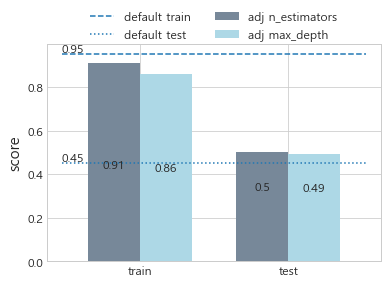

In [97]:
score_set = np.round([score_train, score_test], 2)
tuning_score_set1 = np.round([score_train_pre1, score_test_pre1], 2)
tuning_score_set2 = np.round([score_train_pre2, score_test_pre2], 2)

index = np.arange(len(score_set))
bar_width = 0.35
bottom = 0.8
list_set = [tuning_score_set1, tuning_score_set2]
line_set = ['--', ':']
names = ['train', 'test']

for i, line_set, name in zip(index, line_set, names):
    plt.hlines(score_set[i], xmin=0-bar_width,
               xmax=index[-1]+2*bar_width,
               linestyle=line_set, label='default {}'.format(name))
    plt.text(0-bar_width, score_set[i]+0.01, str(score_set[i]))

plt.bar(index, tuning_score_set1, width=bar_width, label='adj n_estimators',color='lightslategray')
plt.bar(index+bar_width, tuning_score_set2, width=bar_width, label='adj max_depth',color='lightblue')

for i, ts, te in zip(index, tuning_score_set1, tuning_score_set2):
    plt.text(i, (bottom+ts)/4, str(ts), horizontalalignment='center')
    plt.text(i+bar_width, (bottom+te)/4, str(te), horizontalalignment='center')

plt.xticks(index+bar_width/2, names)
plt.ylabel('score', size=15)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fancybox=True, shadow=False);
plt.savefig('RandomForest_score_plot.png')

### grdient boosting

In [98]:
gb_reg = ensemble.GradientBoostingRegressor(random_state=0,loss='ls')
gb_reg.fit(X_train,y_train)
score_train = gb_reg.score(X_train, y_train) # train set 정확도
print('{:.3f}'.format(score_train))
score_test = gb_reg.score(X_test, y_test) # 일반화 정확도
print('{:.3f}'.format(score_test))

0.794
0.497


In [99]:
gb_reg = ensemble.GradientBoostingRegressor(random_state=0,max_depth=5,loss='ls')
gb_reg.fit(X_train,y_train)
score_train1 = gb_reg.score(X_train, y_train) # train set 정확도
print('{:.3f}'.format(score_train1))
score_test1 = gb_reg.score(X_test, y_test) # 일반화 정확도
print('{:.3f}'.format(score_test1))

0.931
0.497


In [100]:
gb_reg = ensemble.GradientBoostingRegressor(random_state=0,max_depth=5,subsample=0.8,loss='ls')
gb_reg.fit(X_train,y_train)
score_train2 = gb_reg.score(X_train, y_train) # train set 정확도
print('{:.3f}'.format(score_train2))
score_test2 = gb_reg.score(X_test, y_test) # 일반화 정확도
print('{:.3f}'.format(score_test2))

0.950
0.520


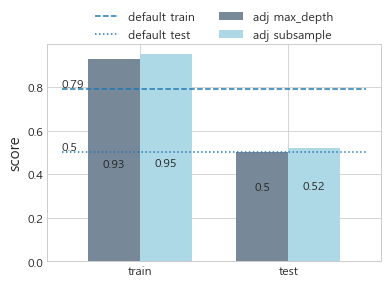

In [101]:
score_set = np.round([score_train, score_test], 2)
tuning_score_set1 = np.round([score_train1, score_test1], 2)
tuning_score_set2 = np.round([score_train2, score_test2], 2)

index = np.arange(len(score_set))
bar_width = 0.35
bottom = 0.8
list_set = [tuning_score_set1, tuning_score_set2]
line_set = ['--', ':']
names = ['train', 'test']

for i, line_set, name in zip(index, line_set, names):
    plt.hlines(score_set[i], xmin=0-bar_width,
               xmax=index[-1]+2*bar_width,
               linestyle=line_set, label='default {}'.format(name))
    plt.text(0-bar_width, score_set[i]+0.01, str(score_set[i]))

plt.bar(index, tuning_score_set1, width=bar_width, label='adj max_depth',color='lightslategray')
plt.bar(index+bar_width, tuning_score_set2, width=bar_width, label='adj subsample',color='lightblue')

for i, ts, te in zip(index, tuning_score_set1, tuning_score_set2):
    plt.text(i, (bottom+ts)/4, str(ts), horizontalalignment='center')
    plt.text(i+bar_width, (bottom+te)/4, str(te), horizontalalignment='center')

plt.xticks(index+bar_width/2, names)
plt.ylabel('score', size=15)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fancybox=True, shadow=False);
plt.savefig('gb_reg_score_plot.png')

In [102]:
# linear regression
reg = LinearRegression()
reg.fit(X=X_train,y=y_train)
# # DecisionTree
# dt = DecisionTreeRegressor(random_state=20)
# dt.fit(X=X_train,y=y_train)
# RandomForest
rf = RandomForestRegressor(n_estimators=5,random_state=0,criterion='mse')
rf.fit(X=X_train,y=y_train)
# Grandient Boosting
gb_reg = ensemble.GradientBoostingRegressor(random_state=0,max_depth=5,subsample=0.8,loss='ls')
gb_reg.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=5, random_state=0, subsample=0.8)

### regression

In [103]:
print(reg.score(X_train,y_train))
print(reg.score(X_test,y_test))

0.6251808624991315
0.346967943231852


In [104]:
import statsmodels.api as sm
OLS = sm.OLS(y_train, X_train).fit()
print(OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                  평균시청률   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     19.02
Date:                Wed, 17 Feb 2021   Prob (F-statistic):          1.09e-130
Time:                        18:19:56   Log-Likelihood:                -2590.0
No. Observations:                 894   AIC:                             5326.
Df Residuals:                     821   BIC:                             5676.
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
배우_방송              0.0446      0.022      2.

In [105]:
# model score
print(reg.score(X_train, y_train))
# print(dt.score(X_train, y_train))
print(rf.score(X_train, y_train))
print(gb_reg.score(X_train, y_train))

0.6251808624991315
0.9071808373442769
0.9504748873130432


In [106]:
# 예측
reg_pred_value = reg.predict(X_test)
# dt_pred_value = dt.predict(X_test)
rf_pred_value = rf.predict(X_test)
gb_reg_pred_value = gb_reg.predict(X_test)
rf_pred_value

array([ 6.60786765,  4.1745    ,  4.07633333,  2.626     ,  6.00286765,
        3.6914881 , 13.41833333,  4.883     ,  4.24132143,  1.12925   ,
        0.92867424, 11.94      , 11.8308254 ,  5.07633333,  7.37058333,
        4.94458333,  2.38      ,  4.1025    ,  8.5025    ,  3.5875    ,
        2.08775   ,  1.52275   ,  2.26680952,  2.5635    ,  5.71791667,
        2.27125   ,  2.71928333,  8.87016667, 11.75466667,  8.2265    ,
        8.11091667,  2.16541667,  2.04083333, 24.476     ,  7.811     ,
        4.79458333,  3.04155769, 28.32733333,  5.16583333,  1.9047    ,
        7.9275    , 19.992     ,  4.16175   ,  7.22308333,  0.96525   ,
        7.87725242,  2.91541667,  9.10941667,  1.90202632,  2.02583333,
        3.88791667,  5.54425641,  3.09125   ,  8.438     ,  2.44775   ,
        2.86459416,  2.86619444,  7.735     ,  6.27833333,  5.4275    ,
        5.16642857,  3.719     ,  1.03083333,  2.8665    ,  4.25375   ,
        2.82125   ,  6.604     ,  2.275     ,  8.54366667,  7.38

In [107]:
yy_test = y_test
yy_test = yy_test.reset_index()
yy_test = yy_test.drop('index',axis=1)

In [108]:
ttest = test
ttest = ttest.reset_index()
ttest = ttest.drop('index',axis=1)

In [109]:
## 허쉬, 경이로운 소문, 펜트하우스, 경우의 수, 사생활, 낭만닥터 김사부 2, 슬기로운 의사생활
ttest_dat = ttest[ttest['드라마 이름'].isin(['허쉬', '경이로운 소문', '펜트하우스', '경우의 수', '사생활', '낭만닥터 김사부 2', '슬기로운 의사생활'])]

In [110]:
ttest_dat = ttest_dat.drop(['드라마 이름','평균시청률','start'],axis=1)

In [132]:
# 특정 드라마 예측하기
reg_pred_drama = reg.predict(ttest_dat)
rf_pred_drama = rf.predict(ttest_dat)
gb_reg_pred_drama = gb_reg.predict(ttest_dat)
reg_pred_drama,rf_pred_drama,gb_reg_pred_drama
pred_drama = np.array(ttest[ttest['드라마 이름'].isin(['허쉬', '경이로운 소문', '펜트하우스', '경우의 수', '사생활', '낭만닥터 김사부 2', '슬기로운 의사생활'])]['평균시청률'])

dat = pd.concat([pd.DataFrame(pred_drama),pd.DataFrame(reg_pred_drama),pd.DataFrame(rf_pred_drama),pd.DataFrame(gb_reg_pred_drama)],axis=1)
dat.columns = ['정답값','회귀','랜덤','부스팅']
dat.index = ['허쉬', '경이로운 소문', '펜트하우스', '경우의 수', '사생활', '낭만닥터 김사부 2', '슬기로운 의사생활']
dat.to_csv('특정드라마 예측.csv',encoding='cp949')

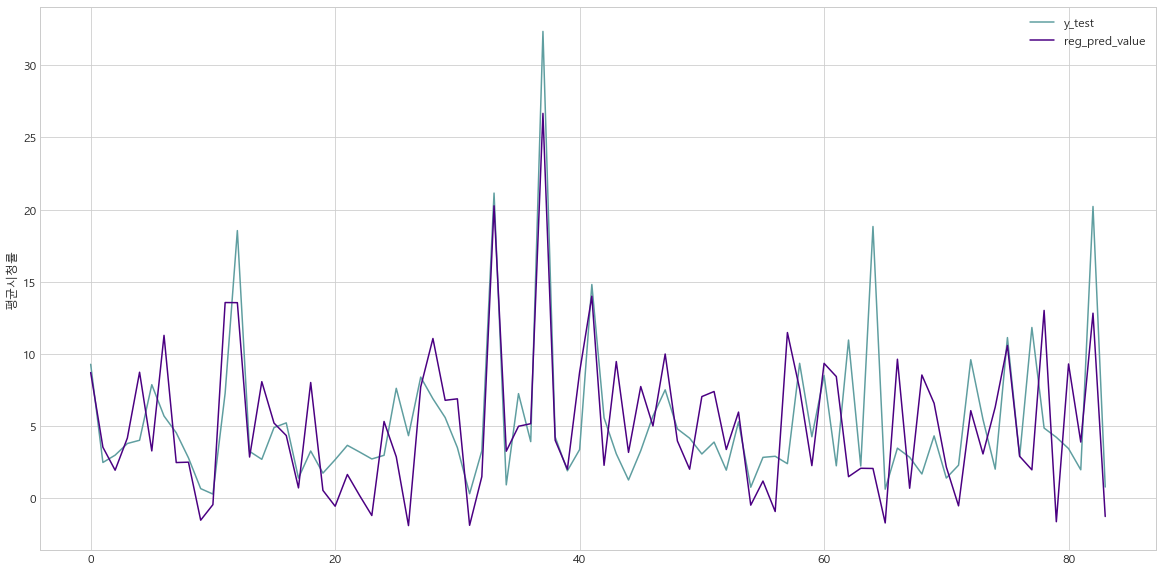

In [49]:
plt.figure(figsize=(20, 10))
plt.plot(yy_test,color='cadetblue')
plt.plot(reg_pred_value,color='indigo')
plt.legend(['y_test', 'reg_pred_value'])
plt.ylabel('평균시청률');
plt.savefig('reg_pre.png')

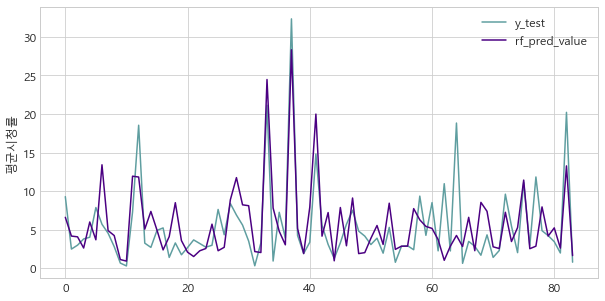

In [519]:
plt.figure(figsize=(10, 5))
plt.plot(yy_test,color='cadetblue')
plt.plot(rf_pred_value,color='indigo')
plt.legend(['y_test', 'rf_pred_value'])
plt.ylabel('평균시청률');
plt.savefig('rf_pre.png')

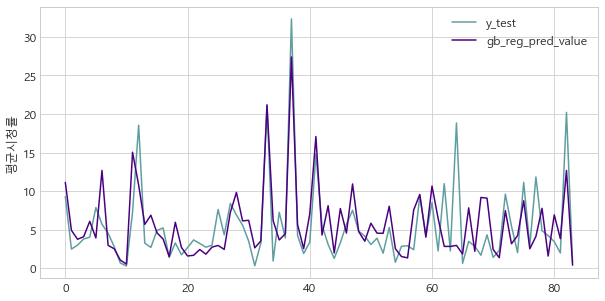

In [520]:
plt.figure(figsize=(10, 5))
plt.plot(yy_test,color='cadetblue')
plt.plot(gb_reg_pred_value,color='indigo')
plt.legend(['y_test', 'gb_reg_pred_value'])
plt.ylabel('평균시청률');
plt.savefig('gb_reg_pre.png')

In [240]:
X_train.columns

Index(['배우_방송', '배우_영화', '드라마활동건수', '영화활동건수', '드라마활동건수.1', '영화활동건수.1', '총 부작',
       '강수량', '기온', '요일시간_10B', '요일시간_10C', '요일시간_11A', '요일시간_11C', '요일시간_11D',
       '요일시간_12A', '요일시간_12B', '요일시간_12C', '요일시간_13A', '요일시간_13B', '요일시간_13C',
       '요일시간_15C', '요일시간_1B', '요일시간_1C', '요일시간_21B', '요일시간_21C', '요일시간_22A',
       '요일시간_22B', '요일시간_22C', '요일시간_24B', '요일시간_24C', '요일시간_2C', '요일시간_3B',
       '요일시간_3C', '요일시간_4B', '요일시간_4C', '요일시간_5C', '요일시간_6C', '요일시간_9C',
       '요일시간_B 22', '방송사_JTBC', '방송사_KBS W', '방송사_KBS1', '방송사_KBS2', '방송사_MBC',
       '방송사_MBC Drama', '방송사_MBC every1', '방송사_MBN', '방송사_OCN', '방송사_SBS',
       '방송사_SBS Plus', '방송사_TV조선', '방송사_tvN', '방송사_드라맥스', '방송사_채널A',
       '스포츠 대회_0', '스포츠 대회_1', 'genre_가족', 'genre_다큐', 'genre_드라마',
       'genre_로맨스', 'genre_막장', 'genre_메디컬', 'genre_법정', 'genre_사극',
       'genre_서스펜스', 'genre_소설', 'genre_수사물', 'genre_스포츠', 'genre_시트콤',
       'genre_액션', 'genre_음식', 'genre_음악', 'genre_정치', 'genre_코메디',
       'genre_타임슬립', 'genre_판타지'],

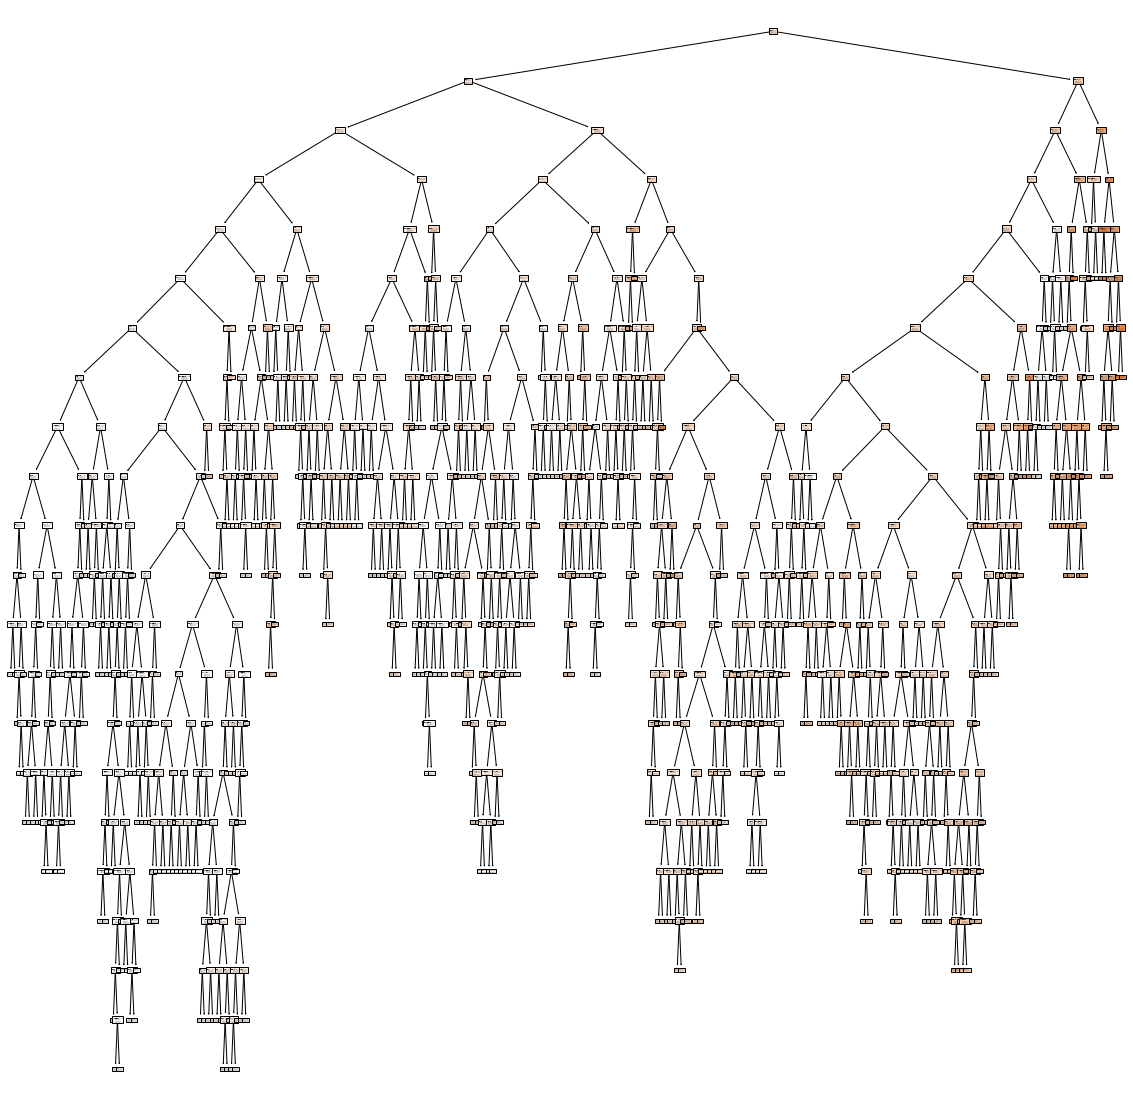

In [247]:
from sklearn import tree
# from dtreeviz.trees import dtreeviz
plt.figure(figsize=(20,20))
_ = tree.plot_tree(rf.estimators_[0], feature_names=X_train.columns, filled=True)

In [248]:
rf.estimators_[0].tree_.max_depth

21

In [257]:
# from dtreeviz.trees import dtreeviz
# viz = dtreeviz(rf.estimators_[0], X_train, y_train, feature_names=X_train.columns, target_name="평균시청률")
# viz

In [37]:
# 측정 : RMSE (Root Mean Squred Error)
reg_RMSE = math.sqrt(mean_squared_error(y_test, reg_pred_value))
# dt_RMSE = math.sqrt(mean_squared_error(y_test, dt_pred_value))
rf_RMSE = math.sqrt(mean_squared_error(y_test, rf_pred_value))
gb_reg_RMSE = math.sqrt(mean_squared_error(y_test, gb_reg_pred_value))
reg_RMSE, rf_RMSE, gb_reg_RMSE

(4.226120513422501, 3.694091728890899, 3.624126913949729)

### importance variables

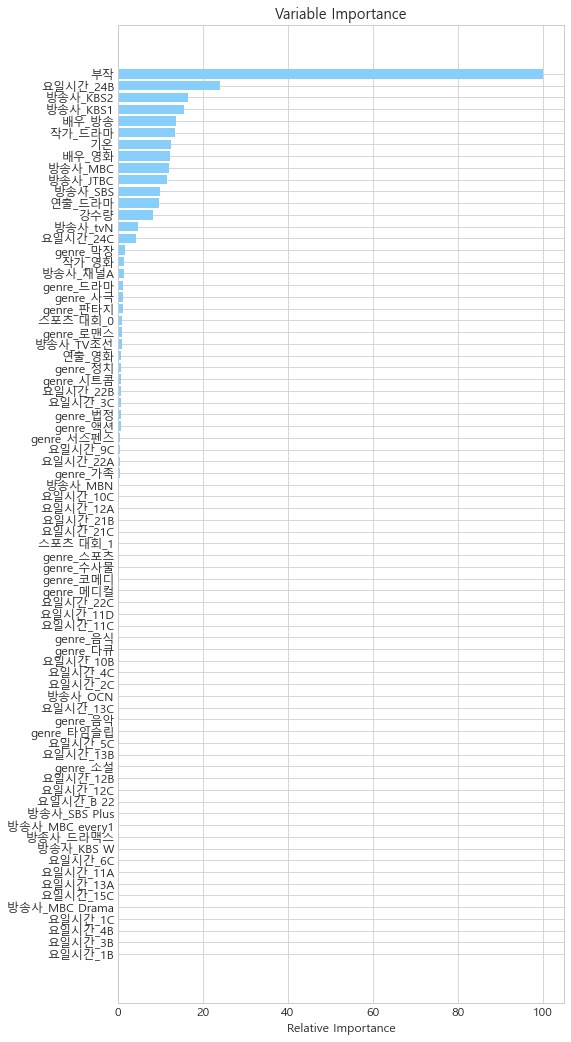

In [521]:
# RandomForest
feature_importance = rf.feature_importances_
feature_importance
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance[sorted_idx], align='center',color='lightskyblue')
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.savefig('rf_importance_var.png')

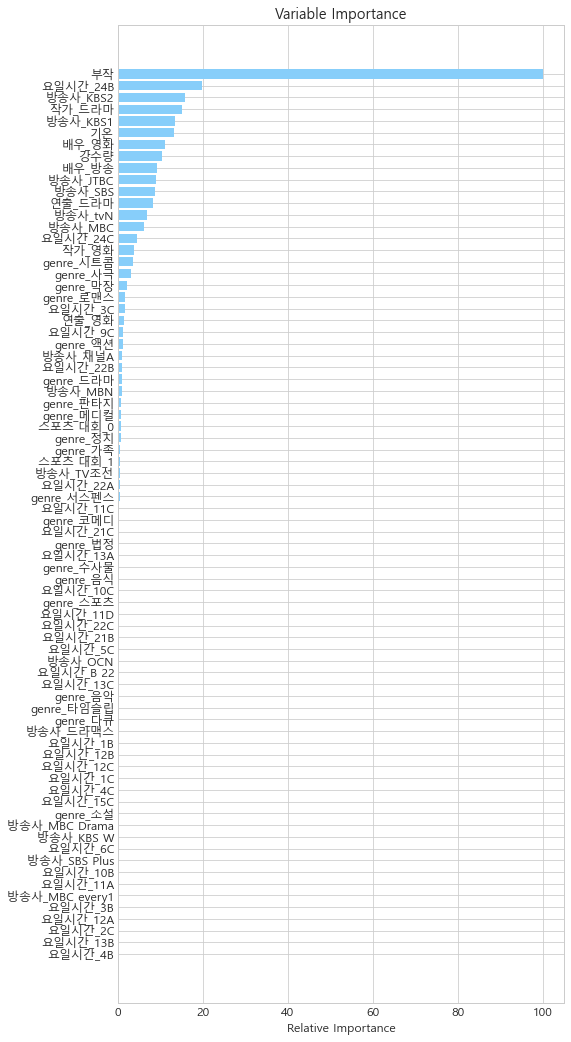

In [522]:
# gradient boosting
feature_importance = gb_reg.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance[sorted_idx], align='center',color='lightskyblue')
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.savefig('gb_reg_importance_var.png')